In [1]:
import torch
import numpy as np
import math
import os
import pytorch_lightning as pl
import torch
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from case_studies.redshift_estimation.catalog import RedshiftFullCatalog, RedshiftTileCatalog
from bliss.encoder.plotting import plot_detections, my_plot_detections
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from einops import rearrange, reduce, repeat

In [2]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "4"

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

environ["BLISS_HOME"] = str("/home/declan/current/bliss")

In [3]:
with initialize(config_path="../", version_base=None):
    cfg = compose("redshift", {
        "predict.weight_save_path=/data/scratch/declan/sdss_encoder_ckpt.ckpt",
        "cached_simulator.cached_data_path=/data/scratch/declan/sdss_like_galaxies"
        })

### Semi-Synthetic Data: SDSS

Let's look at some images generated in this manner. We plot 10 example images, each in the $u,g,r,i,z$ bands. By default, BLISS chooses the SDSS survey with reference band $r$, and we make no modifications to this.

In [4]:
# This cell will take some time to run to load the dataset
pl.seed_everything(cfg.train.seed)

# setup dataset and encoder
dataset = instantiate(cfg.train.data_source)
encoder = instantiate(cfg.train.encoder)

Global seed set to 42


In [5]:
train_dataloader = dataset.train_dataloader() 
batch = next(iter(train_dataloader))
print('Batch of images is of shape {}'.format(batch['images'].shape))

Batch of images is of shape torch.Size([32, 5, 80, 80])


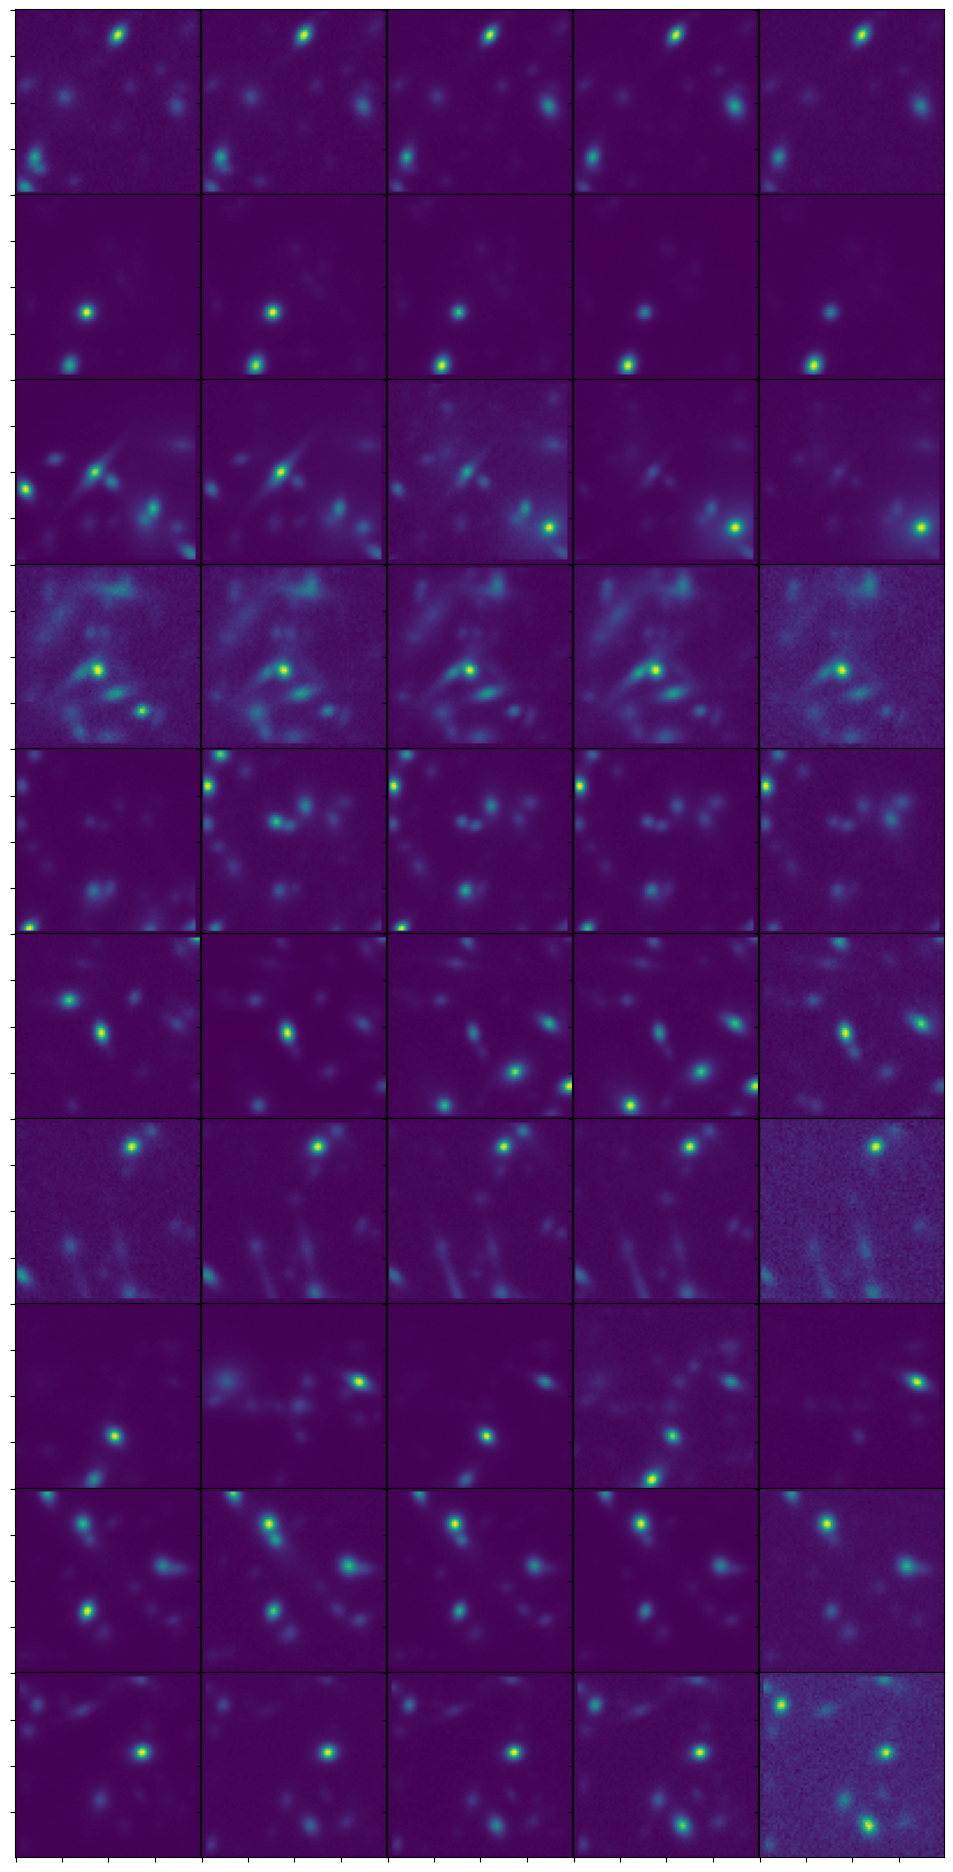

In [6]:
n_to_show = 10
_, axs = plt.subplots(10, 5, figsize=(12,24))
axs = axs.flatten()
imgs = batch['images'][:10].flatten(start_dim=0,end_dim=1)
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    
for a in axs:
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### In-Sample Training Results: SDSS

In [7]:
PATH = "/data/scratch/declan/sdss_encoder_ckpt.ckpt"
checkpoint = torch.load(PATH)
encoder.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [8]:
est_cat = encoder.sample(batch, use_mode=True) # I'm using the mode to predict
est_cat = est_cat.to_dict()

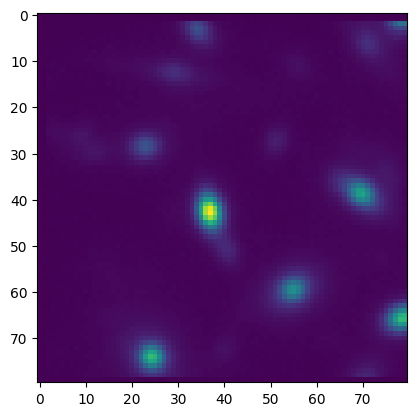

In [9]:
# Plot r_band for a selected image, overlay detected source locations
image_to_show = 5
fig, ax = plt.subplots()
ax.imshow(batch['images'][image_to_show].sum(0)) # Coadd by simple summation

In [10]:
target_cat = RedshiftTileCatalog(encoder.tile_slen, batch["tile_catalog"])
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
target_cat_cropped = target_cat.symmetric_crop(encoder.tiles_to_crop)
est_cat = encoder.sample(batch, use_mode=True)

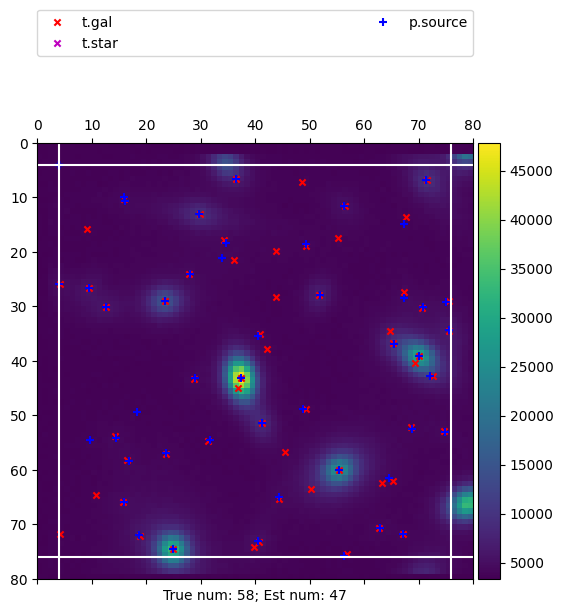

In [11]:
mp = encoder.tiles_to_crop * encoder.tile_slen
fig = my_plot_detections(image_to_show, batch["images"], target_cat_cropped, est_cat, margin_px=mp, figsize=(6,6))

### How Accurate Are The Flux Measurements?

Let's examine predicted galaxy fluxes for detected sources (i.e. the flux magnitudes in bands $(u,g,r,i,z)$) and see how they compare to the true galaxy fluxes for those sources. We start with just one image from one batch.

In [12]:
def u_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,0]

def g_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,1]

def r_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,2]

def i_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,3]

def z_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,4]

def get_photometry_diffs(batch):
    true_fluxes = batch['tile_catalog']['galaxy_fluxes']
    true_sources = batch['tile_catalog']['n_sources']
    
    est_cat = encoder.sample(batch, use_mode=True) # I'm using the mode to predict
    est_cat = est_cat.to_dict()
    
    pred_fluxes = est_cat['galaxy_fluxes']
    pred_sources = est_cat['n_sources']
    
    image_indices, source_tiles_pred_x, source_tiles_pred_y = torch.where(pred_sources != 0)
    
    pred_flux = est_cat['galaxy_fluxes'][image_indices, source_tiles_pred_x, source_tiles_pred_y].squeeze(1)
    true_flux = batch['tile_catalog']['galaxy_fluxes'][image_indices, source_tiles_pred_x, source_tiles_pred_y].squeeze(1)
    
    udiffs = u_abs_diff(pred_flux, true_flux)
    gdiffs = g_abs_diff(pred_flux, true_flux)
    rdiffs = r_abs_diff(pred_flux, true_flux)
    idiffs = i_abs_diff(pred_flux, true_flux)
    zdiffs = z_abs_diff(pred_flux, true_flux)
    
    return udiffs, gdiffs, rdiffs, idiffs, zdiffs
    

In [13]:
u = []
g = []
r = []
i = []
z = []

encoder.eval()
for idx, batch in enumerate(train_dataloader):
    u_d, g_d, r_d, i_d, z_d = get_photometry_diffs(batch)
    u.append(u_d)
    g.append(g_d)
    r.append(r_d)
    i.append(i_d)
    z.append(z_d)
    
    if idx % 10 == 0:
        print("On batch {}...".format(idx))
    

On batch 0...
On batch 10...
On batch 20...
On batch 30...
On batch 40...
On batch 50...
On batch 60...
On batch 70...


KeyboardInterrupt: 

In [14]:
def plot_hists(band_batches, label=None):
    all_diffs = torch.cat(band_batches).detach()
    num_outliers = (all_diffs > 1000).sum()
    all_diffs = all_diffs[torch.where(all_diffs <= 1000)]
    fig,ax = plt.subplots()
    ax.hist(all_diffs, bins=1000)
    ax.set_xlim(0, 40)
    ax.set_title('Photometry Abs Diffs Band {}'.format(label))
    plt.show()
    return
    

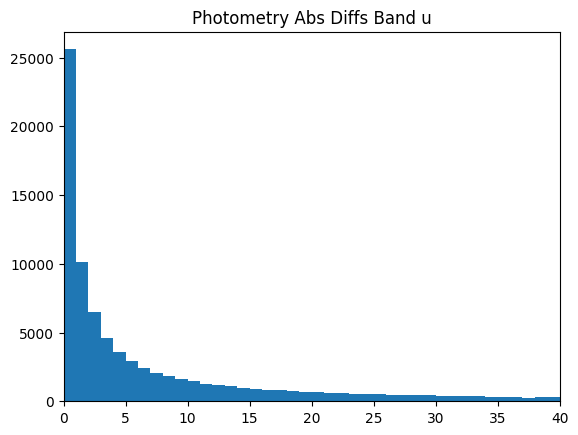

In [15]:
plot_hists(u, 'u')

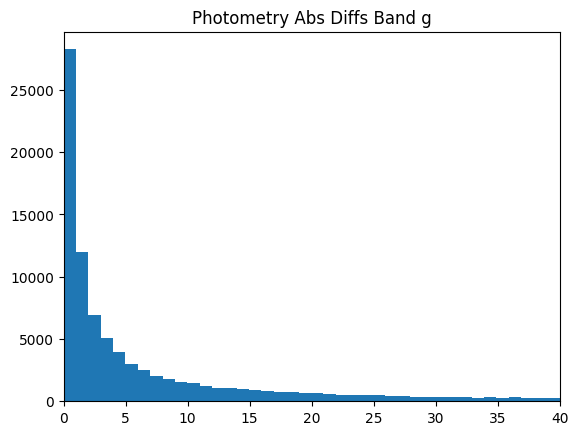

In [16]:
plot_hists(g, 'g')

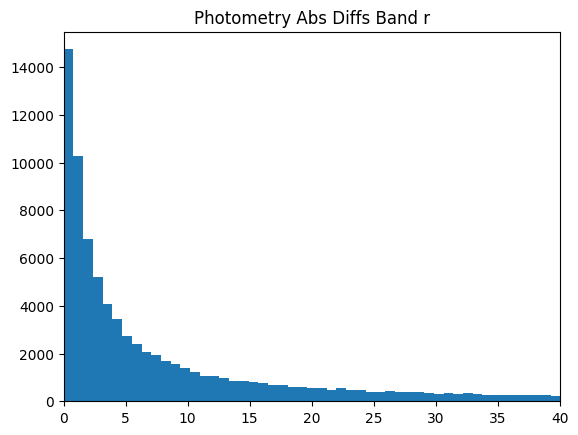

In [17]:
plot_hists(r, 'r')

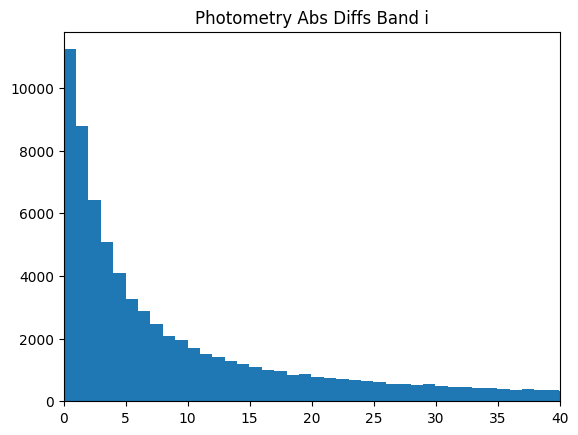

In [18]:
plot_hists(i, 'i')

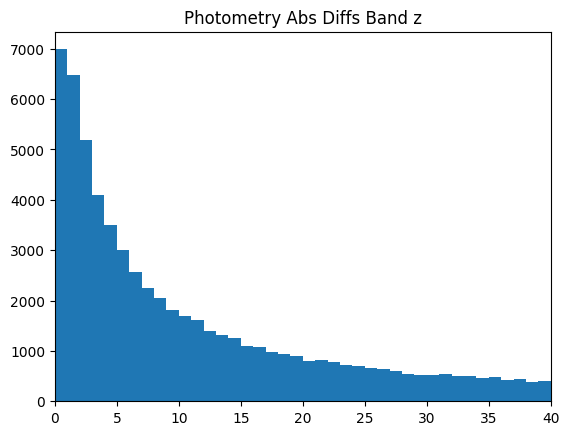

In [19]:
plot_hists(z, 'z')

How much more accurate is a redshift from photometry predictor?

In [21]:
from tqdm import tqdm

class Regressor(torch.nn.Module):
    def __init__(
        self, in_dim, hidden_dim, out_dim, device
    ):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.device = device
        self.loss_fcn = nn.MSELoss()

        self.dense = torch.nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )
        
        self.optimizer = torch.optim.Adam(self.dense.parameters(), lr=1e-3)

    def forward(self, photometry):
        return self.dense(photometry)
    
    def train_one_epoch(self, dataloader):
        losses = []
        for idx, batch in tqdm(enumerate(dataloader), unit='batch'):
            true_fluxes = batch['tile_catalog']['galaxy_fluxes'].squeeze(-2).to(self.device)
            true_redshifts = batch['tile_catalog']['redshifts'].squeeze(-2).to(self.device)
            
            true_fluxes = rearrange(true_fluxes, 'b w h d -> (b w h) d')
            true_redshifts = rearrange(true_redshifts, 'b w h d -> (b w h) d')
            
            self.optimizer.zero_grad()
            loss = self.loss_fcn(self.dense(true_fluxes), true_redshifts)
            loss.backward()
            self.optimizer.step()
            
            losses.append(loss.item())
            
        return torch.tensor(losses).mean()
    
    def train(self, dataloader, n_epochs=100):
        for i in range(n_epochs):
            this_epoch_average_loss = self.train_one_epoch(dataloader)
            print('Epoch {}: Avg. Loss {}'.format(i, this_epoch_average_loss))

In [22]:
reg = Regressor(5, 256, 1, 'cuda')
reg = reg.to('cuda')

In [23]:
reg.train(train_dataloader, n_epochs=10)

6554batch [01:45, 62.25batch/s]


Epoch 0: Avg. Loss 0.3226582407951355


6554batch [01:50, 59.52batch/s]


Epoch 1: Avg. Loss 0.012011805549263954


6554batch [01:51, 58.64batch/s]


Epoch 2: Avg. Loss 0.011745046824216843


6554batch [01:53, 57.73batch/s]


Epoch 3: Avg. Loss 0.011745202355086803


699batch [00:10, 67.19batch/s]


KeyboardInterrupt: 

In [24]:
reg = reg.cpu()

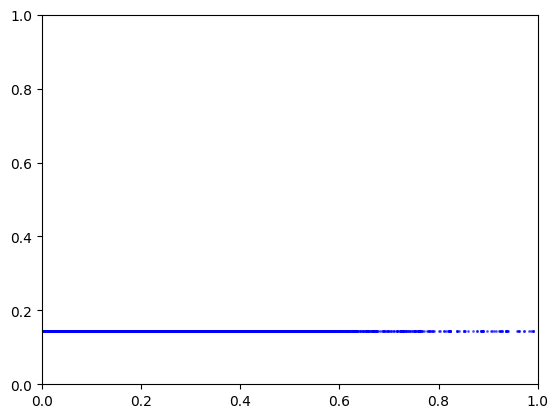

In [25]:
fig, ax = plt.subplots()


for idx, batch in enumerate(train_dataloader):
    
    # Get predicted redshifts
    est_cat = encoder.sample(batch, use_mode=True)
    pred_photometry = est_cat.to_dict()['galaxy_fluxes']
    reshaped_photometry = rearrange(pred_photometry, 'b w h 1 d -> (b w h) d')
    pred_redshifts = reg(reshaped_photometry).squeeze(-1)
    
    # Get true redshifts
    true_redshifts = batch['tile_catalog']['redshifts']
    
    # Cut out border of true_redshifts
    true_redshifts = true_redshifts[:,1:-1,1:-1]
    true_redshifts = true_redshifts.squeeze(-1)
    
    # Reshape 
    true_redshifts = rearrange(true_redshifts, 'b w h 1 -> (b w h)')
    
    # Add this batch to scatterplot
    ax.scatter(true_redshifts.detach().numpy(), pred_redshifts.detach().numpy(), c='b', marker='.', s=5, alpha=0.5)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    if idx > 10:
        break

In [128]:
idx

41

In [129]:
true_redshifts

tensor([0.0803, 0.1421, 0.0950,  ..., 0.1562, 0.3843, 0.1102])

In [130]:
pred_redshifts

tensor([0.1449, 0.1449, 0.1449,  ..., 0.1449, 0.1449, 0.1449],
       grad_fn=<SqueezeBackward1>)

In [131]:
est_cat = encoder.sample(batch, use_mode=True)
pred_photometry = est_cat.to_dict()['galaxy_fluxes']
reshaped_photometry = rearrange(pred_photometry, 'b w h 1 d -> (b w h) d')
pred_redshifts = reg(reshaped_photometry).squeeze(-1)

In [132]:
pred_redshifts

tensor([0.1449, 0.1449, 0.1449,  ..., 0.1449, 0.1449, 0.1449],
       grad_fn=<SqueezeBackward1>)

In [47]:
len(all_diffs)

90960

In [49]:
(all_diffs > 1000).sum()

tensor(1016)

In [40]:
all_diffs = torch.cat(u).detach()

In [41]:
all_diffs.max()

tensor(37740.6953)

In [42]:
all_diffs.min()

tensor(8.9407e-06)

(array([7.2441e+04, 6.3900e+03, 2.9110e+03, 1.8080e+03, 1.1640e+03,
        9.0700e+02, 6.9100e+02, 5.3200e+02, 4.6300e+02, 3.5200e+02,
        2.9700e+02, 2.5600e+02, 2.2500e+02, 2.0500e+02, 1.9400e+02,
        1.5400e+02, 1.2700e+02, 1.3300e+02, 1.3000e+02, 1.1200e+02,
        9.4000e+01, 8.1000e+01, 6.9000e+01, 6.1000e+01, 8.0000e+01,
        3.6000e+01, 6.0000e+01, 4.7000e+01, 3.4000e+01, 4.0000e+01,
        2.7000e+01, 3.8000e+01, 3.7000e+01, 3.8000e+01, 3.1000e+01,
        3.5000e+01, 2.5000e+01, 2.4000e+01, 2.6000e+01, 8.0000e+00,
        2.4000e+01, 1.1000e+01, 2.0000e+01, 2.2000e+01, 2.1000e+01,
        1.4000e+01, 1.3000e+01, 1.3000e+01, 1.0000e+01, 1.0000e+01,
        1.0000e+01, 1.2000e+01, 1.5000e+01, 8.0000e+00, 8.0000e+00,
        1.0000e+01, 1.4000e+01, 1.0000e+01, 9.0000e+00, 5.0000e+00,
        3.0000e+00, 6.0000e+00, 9.0000e+00, 1.1000e+01, 4.0000e+00,
        7.0000e+00, 2.0000e+00, 8.0000e+00, 8.0000e+00, 7.0000e+00,
        8.0000e+00, 9.0000e+00, 3.0000e+00, 3.00

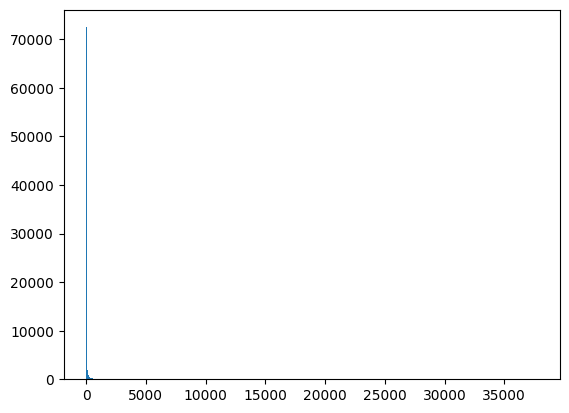

In [46]:
fig, ax = plt.subplots()
ax.hist(all_diffs, bins=1000)

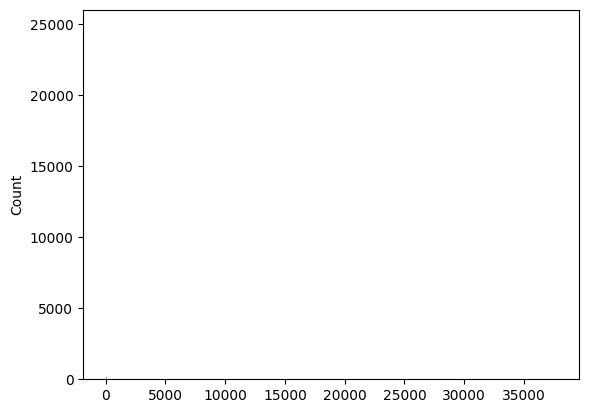

In [38]:
fig_u = plot_hists(u, 'u')

In [39]:
fig_u

<Axes: ylabel='Count'>

In [ ]:
batch['tile_catalog'].keys()

In [ ]:
true_fluxes = batch['tile_catalog']['galaxy_fluxes']
true_sources = batch['tile_catalog']['n_sources']

In [ ]:
pred_fluxes = est_cat.to_dict()['galaxy_fluxes']
pred_sources = est_cat.to_dict()['n_sources']

In [ ]:
pred_fluxes.shape, pred_sources.shape

In [ ]:
source_tiles_x, source_tiles_y = torch.where(true_sources[image_to_show] != 0)
tile_indices_where_source = list(zip(source_tiles_x, source_tiles_y))

In [ ]:
(1,9) in tile_indices_where_source

In [ ]:
batch['tile_catalog']['locs'][image_to_show][1,9]

In [ ]:
est_cat['locs'][image_to_show][0, 8] #subtract 1 due to border elimination

Having hooked up objects correctly by checking location, let's check fluxes. Per the eye test, we're not really detecting sources that aren't there, so let's filter by detected sources.

In [ ]:
image_indices, source_tiles_pred_x, source_tiles_pred_y = torch.where(pred_sources != 0)

In [ ]:
pred_locs = torch.round(est_cat['locs'][image_indices, source_tiles_pred_x, source_tiles_pred_y], decimals=2)

In [ ]:
true_locs = torch.round(batch['tile_catalog']['locs'][image_indices, source_tiles_pred_x+1, source_tiles_pred_y+1], decimals=2)

In [ ]:
pred_locs[100], true_locs[100]

In [ ]:
pred_locs[101], true_locs[101]

In [ ]:
source_tiles_pred_x, source_tiles_pred_y = torch.where(pred_sources[image_to_show] != 0)
tile_indices_where_source_pred = list(zip(source_tiles_pred_x, source_tiles_pred_y))

In [ ]:
torch.round(est_cat['locs'][image_to_show][source_tiles_pred_x, source_tiles_pred_y], decimals=2)

In [ ]:
torch.round(batch['tile_catalog']['locs'][image_to_show][source_tiles_pred_x+1, source_tiles_pred_y+1], decimals=2)

In [ ]:
torch.round(est_cat['galaxy_fluxes'][image_to_show][source_tiles_pred_x, source_tiles_pred_y], decimals=2)

In [ ]:
torch.round(batch['tile_catalog']['galaxy_fluxes'][image_to_show][source_tiles_pred_x+1, source_tiles_pred_y+1], decimals=2)

In [ ]:
def u_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,0]

def g_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,1]

def r_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,2]

def i_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,3]

def z_abs_diff(pred_photometry, true_photometry):
    return torch.abs(pred_photometry - true_photometry)[:,4]

def get_photometry_diffs(batch):
    true_fluxes = batch['tile_catalog']['galaxy_fluxes']
    true_sources = batch['tile_catalog']['n_sources']
    
    est_cat = encoder.sample(batch, use_mode=True) # I'm using the mode to predict
    est_cat = est_cat.to_dict()
    
    pred_fluxes = est_cat.to_dict()['galaxy_fluxes']
    pred_sources = est_cat.to_dict()['n_sources']
    
    image_indices, source_tiles_pred_x, source_tiles_pred_y = torch.where(pred_sources != 0)
    
    pred_flux = est_cat['galaxy_fluxs'][image_indices, source_tiles_pred_x, source_tiles_pred_y].squeeze(1)
    true_flux = batch['tile_catalog']['galaxy_fluxes'][image_indices, source_tiles_pred_x, source_tiles_pred_y].squeeze(1)
    
    udiffs = u_abs_diff(pred_flux, true_flux)
    gdiffs = g_abs_diff(pred_flux, true_flux)
    rdiffs = r_abs_diff(pred_flux, true_flux)
    idiffs = i_abs_diff(pred_flux, true_flux)
    zdiffs = z_abs_diff(pred_flux, true_flux)
    
    return udiffs, gdiffs, rdiffs, idiffs, zdiffs
    

In [ ]:
true_fluxes = batch['tile_catalog']['galaxy_fluxes']
true_sources = batch['tile_catalog']['n_sources']

est_cat = encoder.sample(batch, use_mode=True) # I'm using the mode to predict
est_cat = est_cat.to_dict()

pred_fluxes = est_cat['galaxy_fluxes']
pred_sources = est_cat['n_sources']

image_indices, source_tiles_pred_x, source_tiles_pred_y = torch.where(pred_sources != 0)

pred_flux = est_cat['galaxy_fluxes'][image_indices, source_tiles_pred_x, source_tiles_pred_y].squeeze(1)
true_flux = batch['tile_catalog']['galaxy_fluxes'][image_indices, source_tiles_pred_x, source_tiles_pred_y].squeeze(1)

In [ ]:
pred_flux.shape

In [ ]:
true_flux.shape

Evidently, we're not doing terribly at predicting sources or their locations; let's assume then that we havne't broken the existing functionality of BLISS. We're interested in the quality of our photometric redshift estimates though. Let's plot these in a scatterplot across the whole training set. This will be quite a dense scatterplot because of the sheer number of images we train on.

In [ ]:
fig, ax = plt.subplots()


for idx, batch in enumerate(train_dataloader):
    est_cat = encoder.sample(batch, use_mode=True)
    pred_redshifts = est_cat.to_dict()['redshifts']
    true_redshifts = batch['tile_catalog']['redshifts']
    
    # Cut out border of true_redshifts
    true_redshifts = true_redshifts[:,1:-1,1:-1]
    true_redshifts = true_redshifts.squeeze(-1)
    
    # Add this batch to scatterplot
    ax.scatter(true_redshifts.detach().numpy(), pred_redshifts.detach().numpy(), c='b', marker='.', s=5, alpha=0.5)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    if idx > 1000:
        break

Very poor.

In [ ]:
training_mean = 0.
for idx, batch in enumerate(train_dataloader):
    true_redshifts = batch['tile_catalog']['redshifts']
    n_batch = 32*18*18
    sum_this_batch = true_redshifts.sum()
    training_mean = (training_mean * (idx * n_batch) + sum_this_batch)/((idx+1)*n_batch)
    
print('Mean of Training Redshifts: {}'.format(training_mean))

### Prior Catalog Construction: DC2

We use the DC2 truth tables to get redshifts and photometry values. There is a large number of galaxies in these, so we filter down to only about 5 million or so to use in our empirical prior. As above, the prior of galaxies samples a vector of values `(redshift, u,g,r,i,z)` uniformly from these objects. 

As above, we only sample galaxies not stars.

In [ ]:
with initialize(config_path="../", version_base=None):
    cfg = compose("redshift", {
        "predict.weight_save_path=/data/scratch/declan/dc2_encoder_ckpt.ckpt",
        "cached_simulator.cached_data_path=/data/scratch/declan/dc2_like_galaxies"
        })

### Semi-Synthetic Data: DC2

In [ ]:
# This cell will take some time to run to load the dataset
pl.seed_everything(cfg.train.seed)

# setup dataset and encoder
dataset = instantiate(cfg.train.data_source)
encoder = instantiate(cfg.train.encoder)

In [ ]:
train_dataloader = dataset.train_dataloader() 
batch = next(iter(train_dataloader))
print('Batch of images is of shape {}'.format(batch['images'].shape))

In [ ]:
n_to_show = 10
_, axs = plt.subplots(10, 5, figsize=(12,24))
axs = axs.flatten()
imgs = batch['images'][:10].flatten(start_dim=0,end_dim=1)
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    
for a in axs:
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### In-Sample Training Results: DC2

We fit the encoder using the BLISS pipeline. Essentially, photo-$z$ estimation is performed via a module in parallel to the existing pipeline: the current pipeline estimates locations, types, and fluxes of each astronomical object. We simply add outputs to the encoder network that are used to parameterize the variational distributions on redshift.

Currently, the variational distributions on redshift are univariate Gaussian; a mixture of Gaussians could be used in the future. As with other quantities, the per-tile NLL contribution for redshift is conditioned on the presence of a true source in that tile, etc. We leave other aspects of BLISS unchanged, so in addition we also estimate the number of sources, the type of each source, the fluxes and galaxy parameters of each source, etc.

Let's load the fitted encoder and check that we are detecting sources properly. We overlay red "x"s on the posterior mode per-tile of the detected source, if a source is detected in that tile. We'll just overlay on top of the r-band image, as we don't have coaddition support for SDSS.

In [ ]:
PATH = "/data/scratch/declan/dc2_encoder_ckpt.ckpt"
checkpoint = torch.load(PATH)
encoder.load_state_dict(checkpoint['state_dict'])

In [ ]:
est_cat = encoder.sample(batch, use_mode=True) # I'm using the mode to predict
est_cat = est_cat.to_dict()

In [ ]:
# Plot r_band for a selected image, overlay detected source locations
image_to_show = 8
fig, ax = plt.subplots()
ax.imshow(batch['images'][image_to_show].sum(0)) # Coadd by simple summation

In [ ]:
target_cat = RedshiftTileCatalog(encoder.tile_slen, batch["tile_catalog"])
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
target_cat_cropped = target_cat.symmetric_crop(encoder.tiles_to_crop)
est_cat = encoder.sample(batch, use_mode=True)

In [ ]:
mp = encoder.tiles_to_crop * encoder.tile_slen
fig = my_plot_detections(image_to_show, batch["images"], target_cat_cropped, est_cat, margin_px=mp, figsize=(6,6))

Evidently, we're not doing terribly at predicting sources or their locations; let's assume then that we havne't broken the existing functionality of BLISS. We're interested in the quality of our photometric redshift estimates though. Let's plot these in a scatterplot across the whole training set. This will be quite a dense scatterplot because of the sheer number of images we train on.

In [ ]:
fig, ax = plt.subplots()


for idx, batch in enumerate(train_dataloader):
    est_cat = encoder.sample(batch, use_mode=True)
    pred_redshifts = est_cat.to_dict()['redshifts']
    true_redshifts = batch['tile_catalog']['redshifts']
    
    # Cut out border of true_redshifts
    true_redshifts = true_redshifts[:,1:-1,1:-1]
    true_redshifts = true_redshifts.squeeze(-1)
    
    # Add this batch to scatterplot
    ax.scatter(true_redshifts.detach().numpy(), pred_redshifts.detach().numpy(), c='b', marker='.', s=5, alpha=0.5)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)
    
    if idx > 100:
        break

In [ ]:
training_mean = 0.
for idx, batch in enumerate(train_dataloader):
    true_redshifts = batch['tile_catalog']['redshifts']
    n_batch = 32*18*18
    sum_this_batch = true_redshifts.sum()
    training_mean = (training_mean * (idx * n_batch) + sum_this_batch)/((idx+1)*n_batch)
    
print('Mean of Training Redshifts: {}'.format(training_mean))

In [ ]:
target_cat = RedshiftTileCatalog(encoder.tile_slen, batch["tile_catalog"])
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
target_cat_cropped = target_cat.symmetric_crop(encoder.tiles_to_crop)
est_cat = encoder.sample(batch, use_mode=True)

In [ ]:
def marginal_detections(pred_marginal):  # noqa: WPS430
        return pred_marginal.sample(use_mode=False)

pred = encoder.infer(batch, marginal_detections)

In [ ]:
pred['marginal'].factors['redshift'].scale